In [1]:
import sys
sys.path.append('/Users/sam/All-Program/App/ObjectDetection/')

import logging
logging.basicConfig(level=logging.DEBUG, filename="logfile.log", filemode="w",
                    format="%(asctime)-15s %(levelname)-8s %(message)s")

import numpy as np
from scipy import ndimage
from scipy import misc
from MaskRCNN.visualize import Visualize

from MaskRCNN.main_debug import Inference

%matplotlib inline 

pretrained_weights_path = '/Users/sam/All-Program/App-DataSet/ObjectDetection/MaskRCNN/mask_rcnn_coco.h5'
save_dir = '/Users/sam/All-Program/App-DataSet/ObjectDetection/MaskRCNN/debug_outputs/'

Using TensorFlow backend.


In [2]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# When Proposals are detection
------

It seems that the proposals 30 proposals are able to capture all the important object in the image.

In [2]:
image_metas = Inference.get_image_metas(save_dir)
proposal_normed = Inference.get_proposals(save_dir)
print (proposal_normed.shape)
proposal_normed = np.expand_dims(np.column_stack((proposal_normed[0], np.array(np.ones((1000,2)), dtype='int32'))), axis=0)
detections_dnormed, class_ids, scores = Inference.get_detection_dnormed(image_metas, proposal_normed)
print ('detections_dnormed ',detections_dnormed[0])

(1, 1000, 4)
detections_normed.shape  (1, 1000, 6)
image_shape  [1024 1024    3]
original_image_shape  [476 640   3]
image_window  [ 131    0  893 1024]
RUNNING utils (denorm_boxes)......................
detections_dnormed  [[221  56 388 219]
 [427 529 451 606]
 [199 168 238 204]
 ..., 
 [192  67 234 110]
 [209  64 231  77]
 [ 65 342 329 502]]


## Vizualize Detections

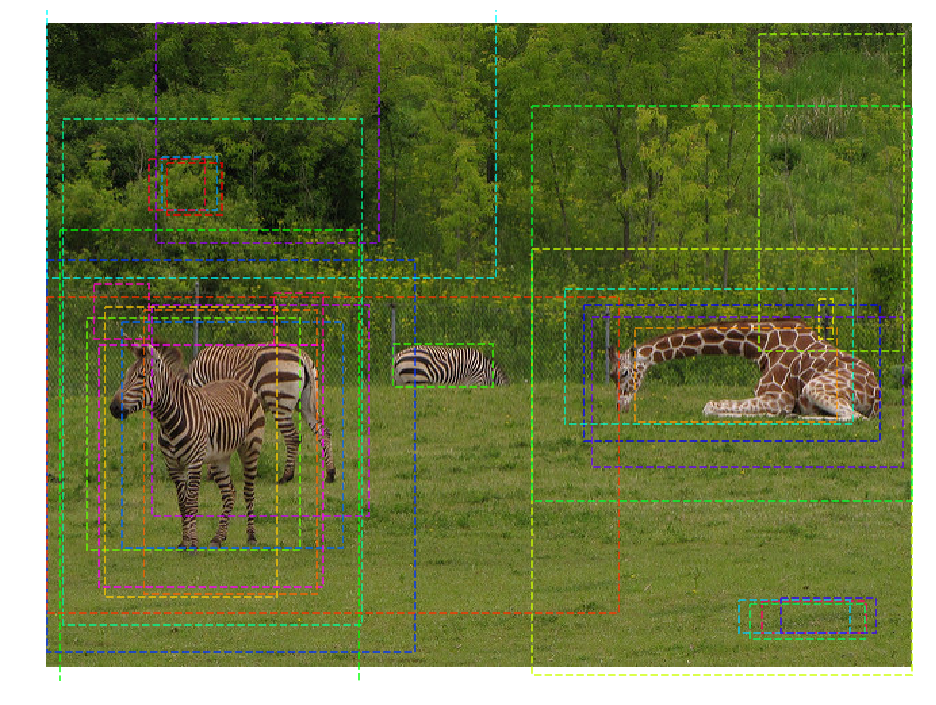

In [3]:
img_path = '/Users/sam/All-Program/App-DataSet/ObjectDetection/images/3627527276_6fe8cd9bfe_z.jpg'
Visualize(img_path).visualize_boxes(boxes=detections_dnormed[0][0:30])

# Using Pooled Rois form MaskRCNN module. And plotting Pooled Rois features [7x7]
--------

In [3]:
Inference(pretrained_weights_path, run='mrcnn', save=True, save_dir=save_dir, DEBUG=False)
mrcnn_class_probs, mrcnn_bbox, pooled_rois = Inference.get_mrcnn_probs_bbox(save_dir)
print(mrcnn_class_probs.shape)
print(mrcnn_bbox.shape)
print(pooled_rois.shape)

Max and Min Proposals,  1.0 0.0
Num NaN present in Proposals  0
(MRCNN) feature_map (len)  4
(MRCNN) proposals (shape)  (1, 1000, 4)
(MRCNN) Pooled Roi's (shape) (1, ?, 7, 7, 256)
(MASK RCNN) mrcnn_class_probs (shape) (1, 1000, 81)
(MASK RCNN) mrcnn_bbox (shape) (1, 1000, 81, 4)
(MASK RCNN) pooled rois (shape) (1, 1000, 7, 7, 256)
(1, 1000, 81)
(1, 1000, 81, 4)
(1, 1000, 7, 7, 256)


In [4]:
rois_to_plot = np.squeeze(pooled_rois[:,20:40, :, :, 100:105])
rois_to_plot = np.transpose(rois_to_plot, [0,3,1,2])
rois_to_plot = rois_to_plot.reshape(-1,7,7)
print (rois_to_plot.shape)
# len(np.split(rois_to_plot, 5, axis=3))#.reshape([20,7,7,-1]).shape

(100, 7, 7)


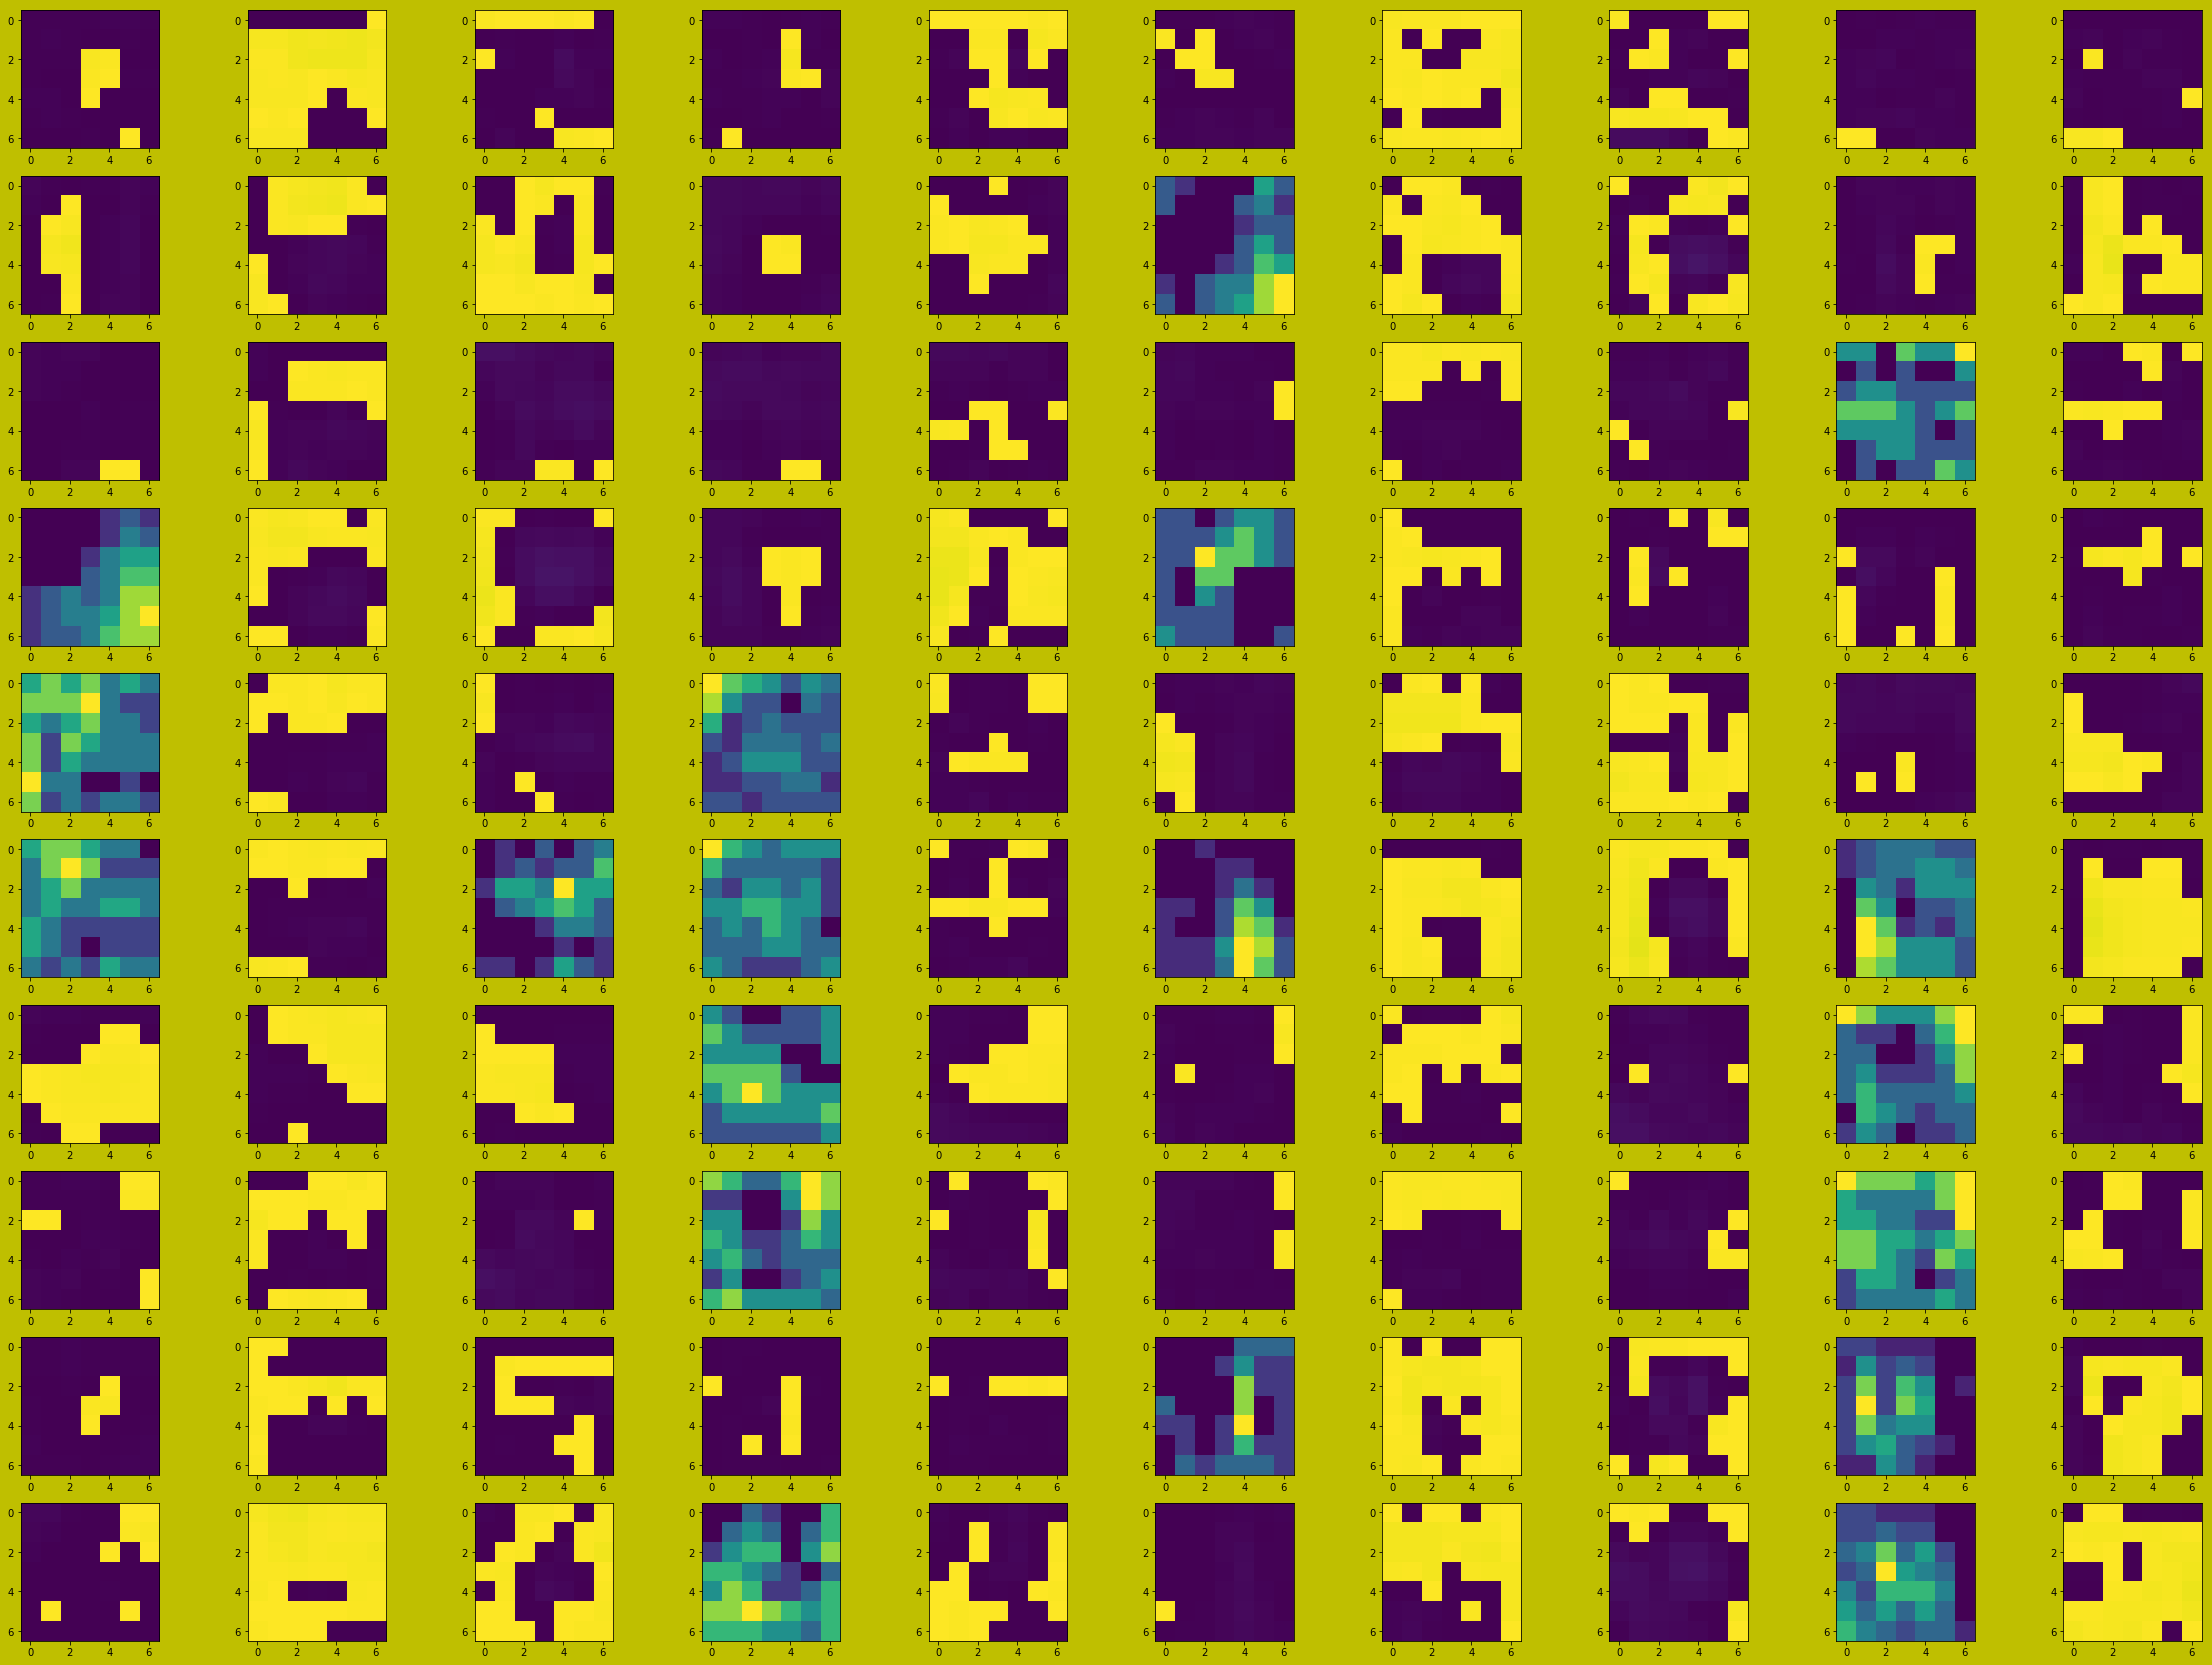

In [5]:
Visualize(rows=10, cols=10, figsize=(40,30)).visualize_image_2d(rois_to_plot)

# When Pre-Back ground filter Detections (Proposals) are detection:
---------

Hmm it seems that the PreNMS Detection can still detect the object towards the left.

Steps:

1. Run the inference for detection and collect 
    * class_ids_pre_bg_filter, class_scores_pre_bg_filter, proposals_pre_bg_filter_list
    * class_ids_pre_nms_post_bg_filter_list, class_scores_pre_nms_post_bg_filter_list, proposals_pre_nms_post_bg_filter_list,

Section 1
2. Sort class_scores_pre_bg_filter with ascending scores
3. Gather data for "proposals_pre_bg_filter_list" using step 2 indices
4. Run unmold_detection on "proposals_pre_bg_filter_list"
5. Check first 10 to 50 proposals

Section 2
2. Remove background class, where class_ids_pre_bg_filter = 0
3. Gather data for "proposals_pre_bg_filter_list" using step 2 indices
4. Run unmold_detection on "proposals_pre_bg_filter_list"
5. Check all the proposals

## Note:
* In Section 1, We see that we are able to detect the objects (zebras) at the left corner in the top 10 proposals, which means that their scores are much lower.
* But, In Section 2, We can see that the left object are no more deteted, this means that the objects (zebras) at the left corned are filtered as background object.
### Which means that we have our model is doing bad at classifying objects as background and foreground. But since the scores of the zebras as non object at left is very less (out of 81 classes), this also means that they are classified as non-objects with a very less score. Hence there is room for improviement and we should definitelu check the mrcnn module.


In [31]:
Inference(pretrained_weights_path=pretrained_weights_path, run='detections', save=True, save_dir=save_dir, DEBUG=False)
(_, class_ids_pre_bg_filter, class_scores_pre_bg_filter, proposals_pre_bg_filter_list, 
 class_ids_pre_nms_post_bg_filter_list, class_scores_pre_nms_post_bg_filter_list, 
 proposals_pre_nms_post_bg_filter_list) = Inference.get_detections(save_dir)

# Get the image metas
image_metas = Inference.get_image_metas(save_dir)

class_ids_pre_bg_filter = np.squeeze(class_ids_pre_bg_filter[0])
class_scores_pre_bg_filter = np.squeeze(class_scores_pre_bg_filter)
proposals_pre_bg_filter = np.squeeze(proposals_pre_bg_filter_list[0])
class_ids_pre_nms_post_bg_filter = np.squeeze(class_ids_pre_nms_post_bg_filter_list[0])
class_scores_pre_nms_post_bg_filter = np.squeeze(class_scores_pre_nms_post_bg_filter_list[0])
proposals_pre_nms_post_bg_filter = np.squeeze(proposals_pre_nms_post_bg_filter_list[0])


print ('Pre-bg-filter shapes: ', class_ids_pre_bg_filter.shape, 
       class_scores_pre_bg_filter.shape, 
       proposals_pre_bg_filter.shape)

print ('Post-bg and pre-nms filter shapes: ', class_ids_pre_nms_post_bg_filter.shape, 
       class_scores_pre_nms_post_bg_filter.shape, 
       proposals_pre_nms_post_bg_filter.shape)

1 [[476 640   3]] [[1024 1024    3]] [[ 131    0  893 1024]]
window  [[ 0.12805474  0.          0.87194526  1.        ]]
(DETECTION) detections (shape) (1, 100, 6)
Pre-bg-filter shapes:  (1000,) (1000,) (1000, 4)
Post-bg and pre-nms filter shapes:  (4,) (4,) (4, 4)


## Section 1
------

### Background predictions are not filtered but class scores are sorted descending and boxes are printed.

In [32]:
idx_ascending = np.argsort(class_scores_pre_bg_filter)#[::-1]  
class_ids_pre_bg_filter_ascending = class_ids_pre_bg_filter[idx_desc]
class_scores_pre_bg_filter_ascending = class_scores_pre_bg_filter[idx_desc]
proposals_pre_bg_filter_ascending = proposals_pre_bg_filter[idx_desc,:]
print (class_ids_pre_bg_filter_ascending.shape, 
       class_scores_pre_bg_filter_ascending.shape, 
       proposals_pre_bg_filter_ascending.shape)

(1000,) (1000,) (1000, 4)


In [33]:
pre_bg_filter_detection_ascending = np.column_stack((proposals_pre_bg_filter_ascending,
                                           class_scores_pre_bg_filter_ascending.reshape(-1,1),
                                           class_ids_pre_bg_filter_ascending.reshape(-1,1)))
print (pre_bg_filter_detection_ascending.shape)


# Get the detection on image (Pixel level)
detections_dnormed, class_ids, scores = Inference.get_detection_dnormed(
    image_metas,  np.expand_dims(pre_bg_filter_detection_ascending,axis=0))
print(detections_dnormed[0].shape)

(1000, 6)
detections_normed.shape  (1, 1000, 6)
image_shape  [1024 1024    3]
original_image_shape  [476 640   3]
image_window  [ 131    0  893 1024]
RUNNING utils (denorm_boxes)......................
(1000, 4)


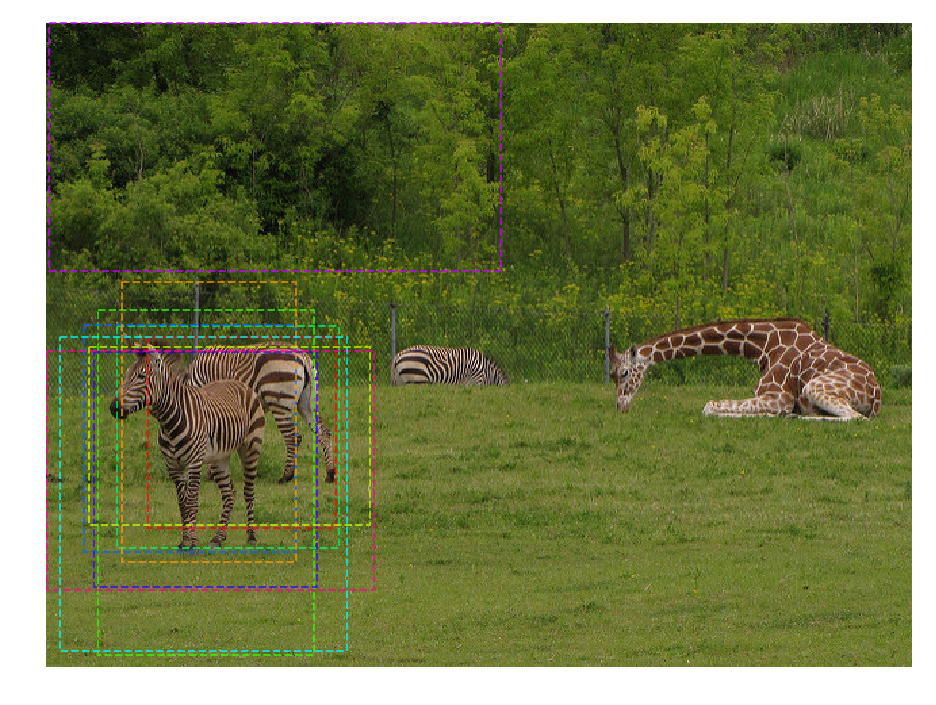

In [34]:
img_path = '/Users/sam/All-Program/App-DataSet/ObjectDetection/images/3627527276_6fe8cd9bfe_z.jpg'
Visualize(img_path).visualize_boxes(boxes=detections_dnormed[0][0:10])

## Section 2
--------
### Filter Background predictions, remove 0 class

In [35]:
idx_filtered_bg = np.where(class_ids_pre_bg_filter > 0)[0]#[: ,0]
class_ids_post_bg_filter = class_ids_pre_bg_filter[idx_filtered_bg]
class_scores_post_bg_filter = class_scores_pre_bg_filter[idx_filtered_bg]
proposals_post_bg_filter = proposals_pre_bg_filter[idx_filtered_bg,:]

print('When Background labels are removed: ', class_ids_post_bg_filter.shape, 
       class_scores_post_bg_filter.shape, 
       proposals_post_bg_filter.shape)


When Background labels are removed:  (21,) (21,) (21, 4)


In [36]:
post_bg_filter_detection = np.column_stack((proposals_post_bg_filter,
                                           class_scores_post_bg_filter.reshape(-1,1),
                                           class_ids_post_bg_filter.reshape(-1,1)))
print (post_bg_filter_detection.shape)


# Get the detection on image (Pixel level)
detections_dnormed, class_ids, scores = Inference.get_detection_dnormed(
    image_metas,  np.expand_dims(post_bg_filter_detection,axis=0))
print(detections_dnormed[0].shape)

(21, 6)
detections_normed.shape  (1, 21, 6)
image_shape  [1024 1024    3]
original_image_shape  [476 640   3]
image_window  [ 131    0  893 1024]
RUNNING utils (denorm_boxes)......................
(21, 4)


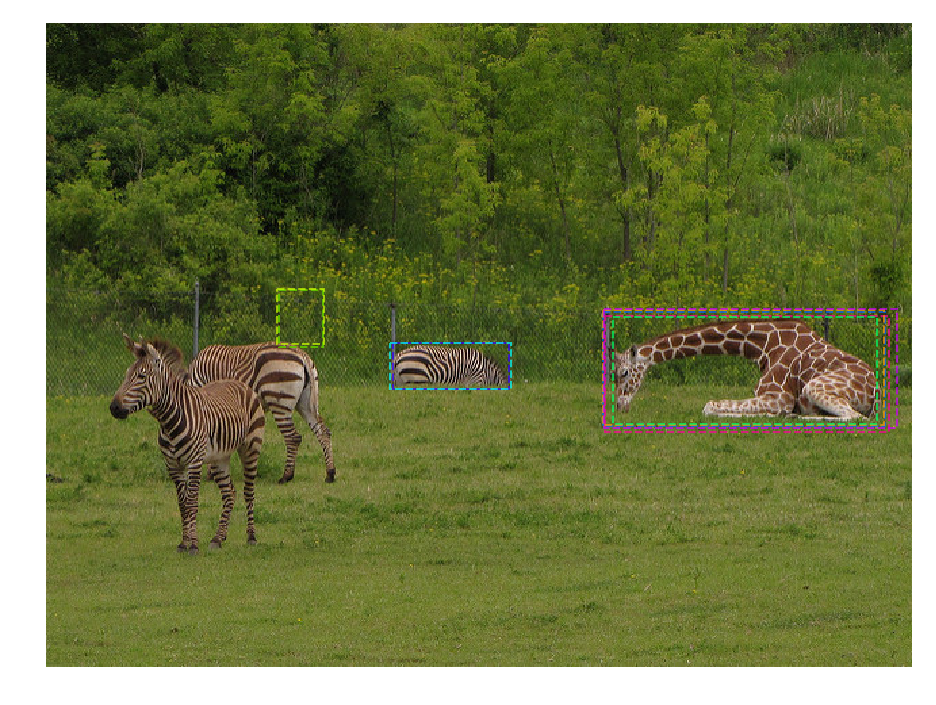

In [37]:
img_path = '/Users/sam/All-Program/App-DataSet/ObjectDetection/images/3627527276_6fe8cd9bfe_z.jpg'
Visualize(img_path).visualize_boxes(boxes=detections_dnormed[0][0:10])

# When Pre-NMS Post-Back ground filter Detections (Proposals) are detection:
---------

Hmm it seems that the PreNMS Detection cant detect the object towards the left.

In [31]:
pre_nms_detections = np.column_stack((pre_nms_proposals_list[0], 
                                     pre_nms_scores_list[0].reshape(-1,1), 
                                     np.ones((4,1))))

detections_dnormed, class_ids, scores = Inference.get_detection_dnormed(
    image_metas,  np.expand_dims(pre_nms_detections,axis=0))
print ('detections_dnormed ',detections_dnormed[0])

detections_normed.shape  (1, 4, 6)
image_shape  [1024 1024    3]
original_image_shape  [476 640   3]
image_window  [ 131    0  893 1024]
image_window_normeed:  [ 0.12805474  0.          0.87194526  1.        ]
(4, 6)
[]
4
Shift scale:  [ 0.12805474  0.          0.12805474  0.        ] [ 0.74389052  1.          0.74389052  1.        ]
boxes  [[ 0.49665636  0.40005708  0.56542829  0.53324699]
 [ 0.49579116  0.39695364  0.56561017  0.53502095]
 [ 0.45433212  0.65440953  0.61985742  0.95258933]
 [ 0.49777832  0.39148855  0.56643595  0.5360806 ]]
RUNNING utils (denorm_boxes)......................
detections_dnormed  [[236 256 270 342]
 [236 254 270 343]
 [216 418 295 610]
 [236 250 270 344]]


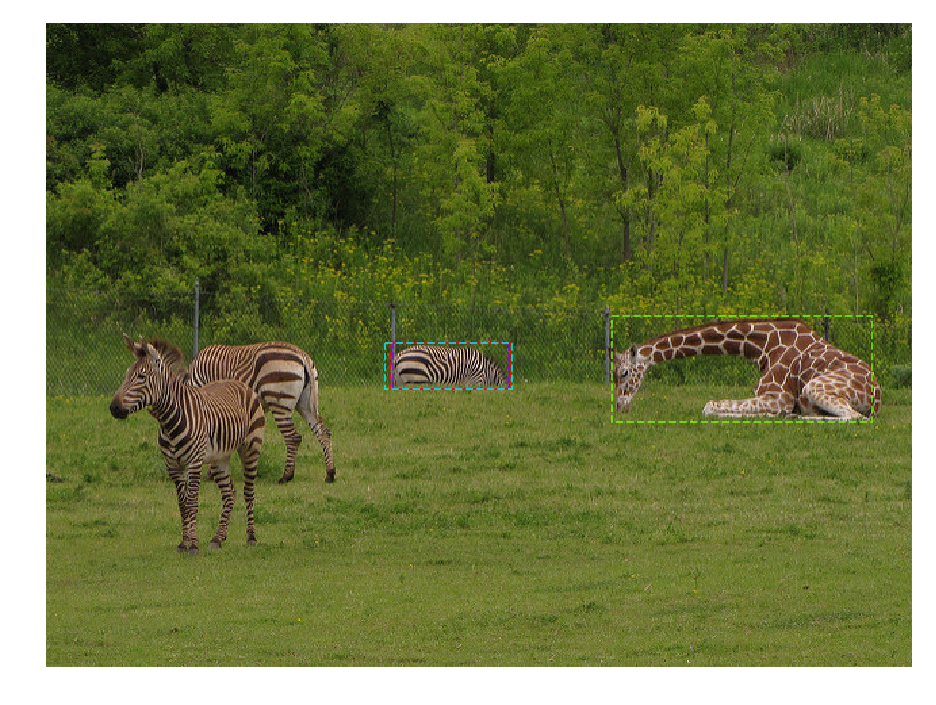

In [32]:
img_path = '/Users/sam/All-Program/App-DataSet/ObjectDetection/images/3627527276_6fe8cd9bfe_z.jpg'
Visualize(img_path).visualize_boxes(boxes=detections_dnormed[0][0:30])

In [18]:
pre_nms_proposals_list[0].shape

(4, 4)

In [21]:
np.expand_dims(pre_nms_proposals_list[0],axis=0).shape

(1, 4, 4)